In [1]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.10.19
    Uninstalling nvidia-curand-cu12-

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import timm

In [2]:
train = pd.read_csv("/kaggle/input/soil-classification-part-2/soil_competition-2025/train_labels.csv")
test = pd.read_csv("/kaggle/input/soil-classification-part-2/soil_competition-2025/test_ids.csv")

In [3]:
train

,image_id,label
0,img_ed005410.jpg,1
1,img_0c5ecd2a.jpg,1
2,img_ed713bb5.jpg,1
3,img_12c58874.jpg,1
4,img_eff357af.jpg,1
...,...,...
1217,img_9ae546bd.jpg,1
1218,img_6e0b1b7c.jpg,1
1219,img_5c4372f8.jpg,1
1220,img_6f5bf9d2.jpg,1


# Cosine Similarity 

In [3]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        path = self.dataframe.iloc[idx]['image_id']
        img_path = f"/kaggle/input/soil-classification-part-2/soil_competition-2025/train/{path}"
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((518, 518)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [6]:
dataset = ImageDataset(dataframe=train, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

model = timm.create_model('vit_base_patch14_dinov2', pretrained=True)
model.reset_classifier(0)  
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

all_embeddings = []
with torch.no_grad():
    for images in dataloader:
        images = images.to(device)
        embeddings = model(images)  # shape: [B, D]
        all_embeddings.append(embeddings.cpu())

soil_centroid = torch.cat(all_embeddings, dim=0).mean(dim=0)
print("Soil centroid embedding shape:", soil_centroid.shape)


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Soil centroid embedding shape: torch.Size([768])


In [4]:
from sklearn.metrics.pairwise import cosine_similarity

class TestImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]['image_id']
        img_path = f"/kaggle/input/soil-classification-part-2/soil_competition-2025/test/{path}"
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, path 

transform = transforms.Compose([
    transforms.Resize((518, 518)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [29]:
test_dataset = TestImageDataset(test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
 
model.eval()
results = []

with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)
        embeddings = model(images)  # Shape: [B, D]
        embeddings = embeddings.cpu()

        sim = cosine_similarity(embeddings.numpy(), soil_centroid.unsqueeze(0).numpy())  # shape: [B, 1]
        preds = (sim >= 0.3).astype(int).flatten()  # threshold can be tuned

        for path, label, score in zip(paths, preds, sim.flatten()):
            results.append({
                "image_id": path,
                "label": label
            })

In [30]:
results_df = pd.DataFrame(results)
print(results_df.head())

                               image_id  label
0  6595f1266325552489c7d1635fafb88f.jpg      1
1  4b614841803d5448b59e2c6ca74ea664.jpg      1
2  ca30e008692a50638b43d944f46245c8.jpg      1
3  6a9046a219425f7599729be627df1c1a.jpg      1
4  97c1e0276d2d5c2f88dddbc87357611e.jpg      1


In [31]:
label_sum = results_df['label'].sum()

print("Sum of label column:", label_sum)

Sum of label column: 314


In [32]:
results_df.to_csv("predicitions_2_cosine_0.2.csv", index=False)

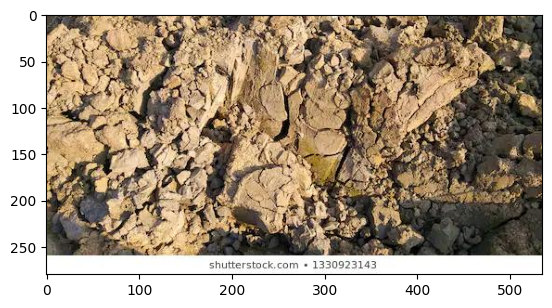

In [20]:
from PIL import Image
import matplotlib.pyplot as plt

path = "/kaggle/input/soil-classification-part-2/soil_competition-2025/test"
image_path = path + "/" +"831b5765c7ff586d84c082fdd062d0f0.jpg"
image = Image.open(image_path)
plt.imshow(image)

# AutoEncoder 

In [5]:
class ConvAutoencoder(nn.Module):
    def __init__(self , latent_dim = 128):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # [B, 32, 112, 112]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # [B, 64, 56, 56]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # [B, 128, 28, 28]
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # [B, 64, 56, 56]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # [B, 32, 112, 112]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),   # [B, 3, 224, 224]
            nn.Tanh()
        )
        dummy_input = torch.zeros(1, 3, 224, 224)
        with torch.no_grad():
            dummy_output = self.encoder(dummy_input)
            self.flatten_dim = dummy_output.view(1, -1).size(1)  # e.g., 128 * 28 * 28 = 100352
        self.encoder_fc = nn.Linear(self.flatten_dim, latent_dim)



    def forward(self, x):
        latent = self.encoder(x)
        return self.decoder(latent)
    def encode(self, x):
        x = self.encoder(x)             # -> [B, C, H, W]
        x = x.view(x.size(0), -1)           # flatten to [B, C*H*W]
        z = self.encoder_fc(x)              # [B, latent_dim]
        return z

    def get_latent(self, x):
        return self.encode(x)


In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ImageDataset(dataframe=train, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    total_loss = 0
    for imgs in dataloader:
        imgs = imgs.to(device)
        recon = model(imgs)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

Epoch 1, Loss: 0.1805
Epoch 2, Loss: 0.0497
Epoch 3, Loss: 0.0399
Epoch 4, Loss: 0.0340
Epoch 5, Loss: 0.0311
Epoch 6, Loss: 0.0290
Epoch 7, Loss: 0.0269
Epoch 8, Loss: 0.0256
Epoch 9, Loss: 0.0240
Epoch 10, Loss: 0.0228


In [8]:
import torch.nn.functional as F

test_dataset = TestImageDataset(test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
model.eval()
results = []

with torch.no_grad():
    for images, paths in test_loader:
        images = images.to(device)

        z = model.get_latent(images)                    # [B, D]
        x_recon = model(images)                         # [B, 3, H, W]
        z_recon = model.get_latent(x_recon)             # [B, D]

        latent_error = F.mse_loss(z, z_recon, reduction='none').mean(dim=1).cpu().numpy()  # shape: [B]
        for path, score in zip(paths, latent_error):
            results.append({
                "image_id": path,
                "latent_error": score,
            })


In [78]:
# errors = np.array([r["reconstruction_error"] for r in reconstruction_scores])
# threshold = np.percentile(errors, 95)  # or tune based on validation set

# for r in reconstruction_scores:
#     r["label"] = int(r["reconstruction_error"] <= threshold)

In [9]:
df = pd.DataFrame(results)

print(df.head())

                               image_id  latent_error
0  6595f1266325552489c7d1635fafb88f.jpg      0.003579
1  4b614841803d5448b59e2c6ca74ea664.jpg      0.004844
2  ca30e008692a50638b43d944f46245c8.jpg      0.015162
3  6a9046a219425f7599729be627df1c1a.jpg      0.012885
4  97c1e0276d2d5c2f88dddbc87357611e.jpg      0.002816


In [12]:
count = (df['latent_error'] > 0.004).sum()
print("Number of latent_score > 0.004:", count)

Number of latent_score > 0.0025: 625


In [13]:
df['label'] = (df['latent_error'] <= 0.004).astype(int)
df.drop(columns=['latent_error'], inplace=True)


In [14]:
df.to_csv("predictions_2_latent_2.csv" , index = False)

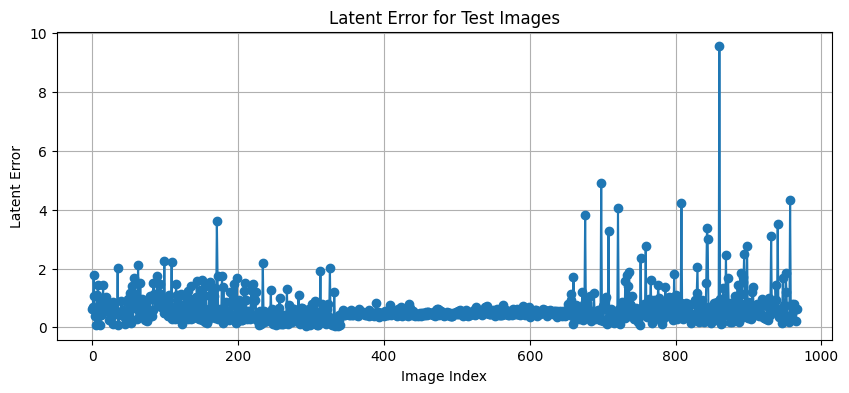

In [129]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(df["latent_error"].values*100, marker='o', linestyle='-')
plt.title("Latent Error for Test Images")
plt.xlabel("Image Index")
plt.ylabel("Latent Error")
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


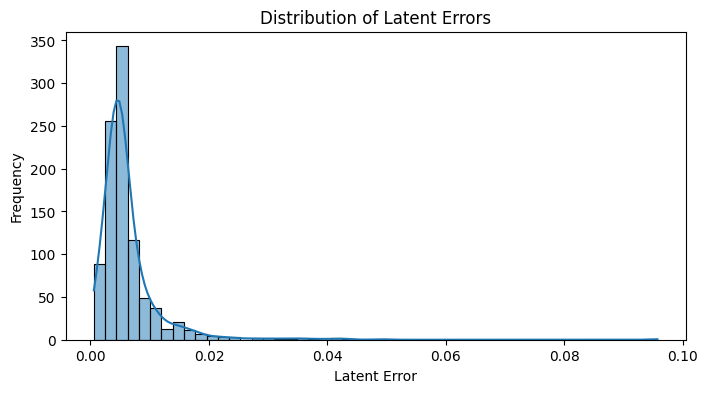

In [130]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(df["latent_error"], bins=50, kde=True)
plt.title("Distribution of Latent Errors")
plt.xlabel("Latent Error")
plt.ylabel("Frequency")
plt.show()
